# Importando as Bibliotecas

In [57]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import time
import psutil
from tensorflow.keras.callbacks import Callback

# Configurar o TensorFlow para GPU

In [31]:
# Configuração de GPUs (se disponível)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrinja o TensorFlow para usar apenas 1 GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


# Definindo os parâmetros

In [71]:
IMAGE_SIZE = 224
BATCH_SIZE = 32        
EPOCHS = 15 # apenas para testar o modelo.          
CHANNELS = 1            


# Montar o diretório

In [41]:
# Diretórios principais
base_dir = "D:\\T.I\\BootcampAvanti_ML\\DeteccaoMelanoma_ML"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Carregar e Pré-processar o Dataset

#### Pré processamento.

- Fazendo o pré processamento direto no dataset, antes de entrar com o tensor flow.

In [ ]:
# Função de pré processamento.

def preprocess_and_save_image(image_path, output_path):
    try:
        # Carregar a imagem
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Erro ao carregar a imagem {image_path}")
            return

        # Converter para escala de cinza
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Aplicar equalização de histograma
        equalized_image = cv2.equalizeHist(gray_image)
        
        # Salvar a imagem pré-processada
        cv2.imwrite(output_path, equalized_image)
    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")

In [ ]:
# Função para processar todas as imagens em um diretório específico
def process_images_in_directory(input_dir, output_dir):
    for subdir in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir)
        processed_subdir_path = os.path.join(output_dir, subdir)
        os.makedirs(processed_subdir_path, exist_ok=True)
        
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                input_path = os.path.join(subdir_path, filename)
                output_path = os.path.join(processed_subdir_path, filename)
                print(f"Processando imagem: {input_path}")
                preprocess_and_save_image(input_path, output_path)
                if not os.path.exists(output_path):
                    print(f"Falha ao salvar a imagem: {output_path}")
                else:
                    print(f"Imagem salva em: {output_path}")

- Montando o diretório com as imagens processadas.

In [38]:
# Já foi feito uma vez não é necessário ser refeito.


processed_train_dir = os.path.join(base_dir, 'processed_train')
processed_test_dir = os.path.join(base_dir, 'processed_test')

# Criação dos diretórios processados se não existirem
os.makedirs(processed_train_dir, exist_ok=True)
os.makedirs(processed_test_dir, exist_ok=True)



# Processar imagens no diretório de treinamento e teste
process_images_in_directory(train_dir, processed_train_dir)
process_images_in_directory(test_dir, processed_test_dir)


Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\1.jpg
Imagem salva em: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\processed_train\Benign\1.jpg
Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\10.jpg
Imagem salva em: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\processed_train\Benign\10.jpg
Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\100.jpg
Imagem salva em: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\processed_train\Benign\100.jpg
Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\1000.jpg
Imagem salva em: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\processed_train\Benign\1000.jpg
Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\1001.jpg
Imagem salva em: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\processed_train\Benign\1001.jpg
Processando imagem: D:\T.I\BootcampAvanti_ML\DeteccaoMelanoma_ML\train\Benign\1002.jpg
Imagem salva em: D:\

# Visualizando os dados

Imagens do diretório original de treinamento:


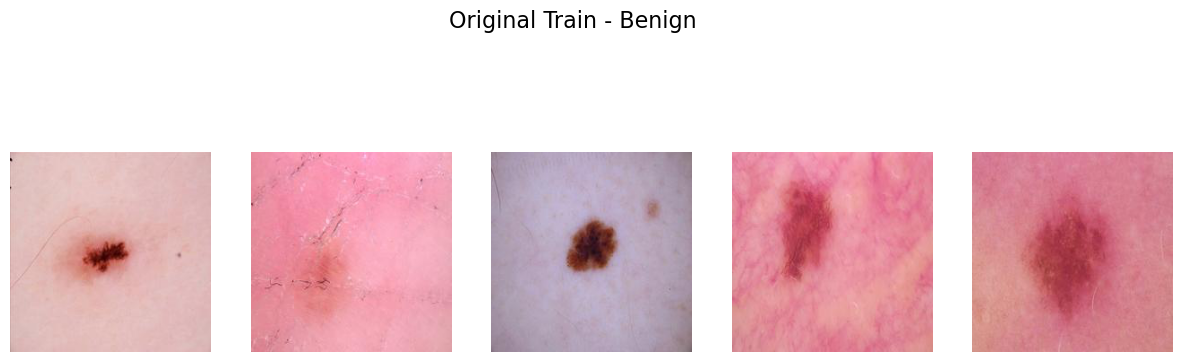

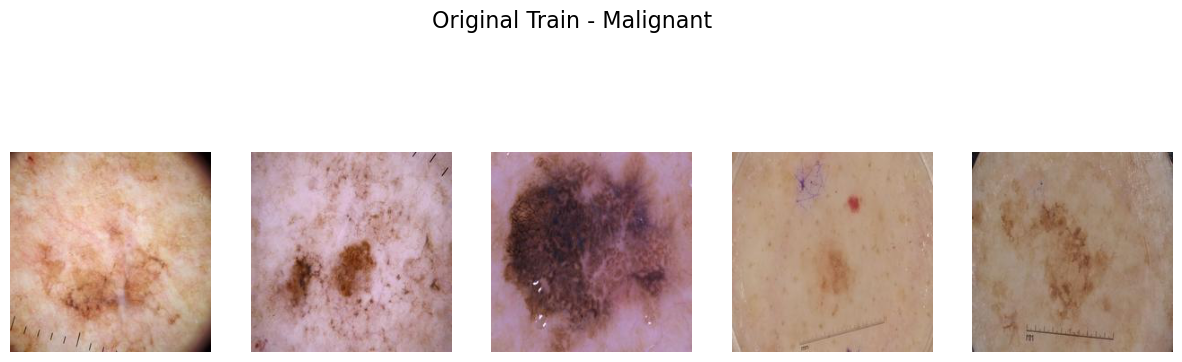

Imagens do diretório original de teste:


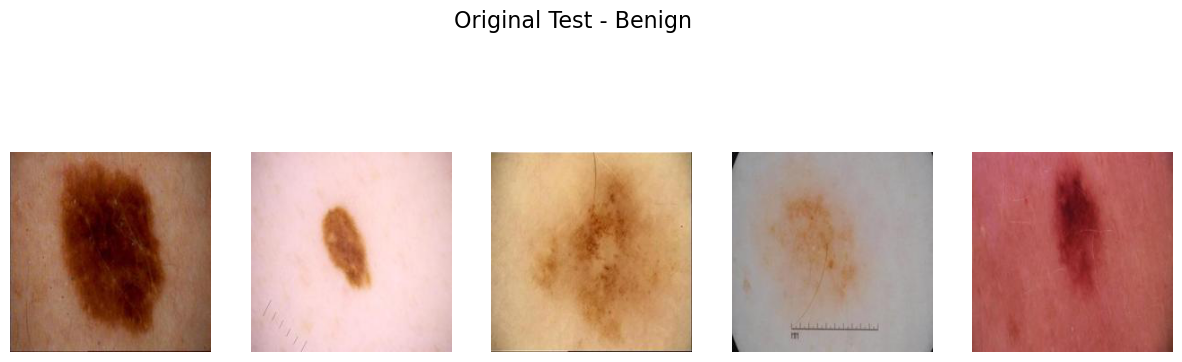

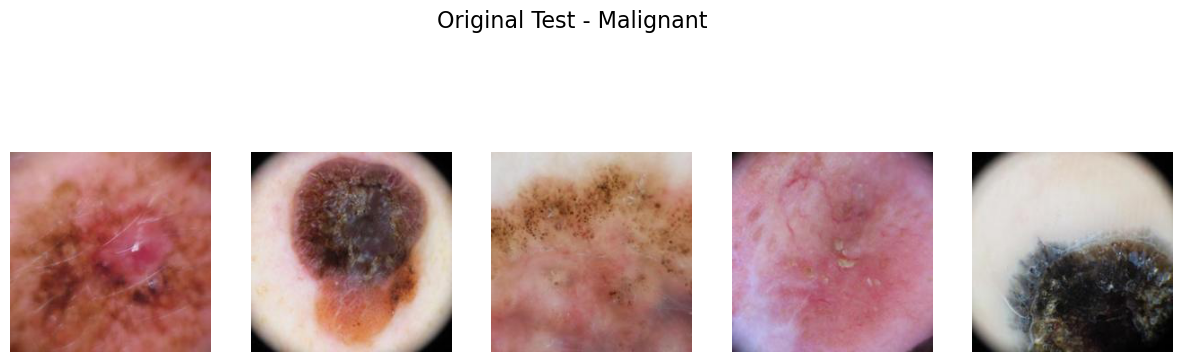

Imagens do diretório processado de treinamento:


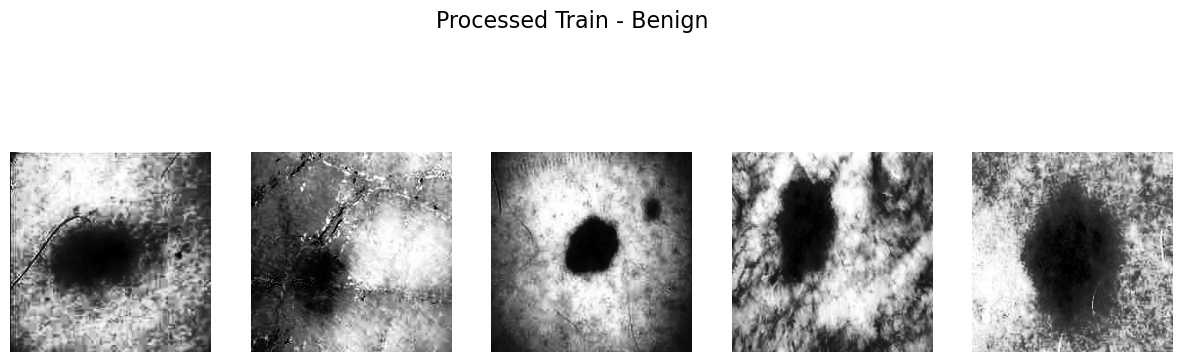

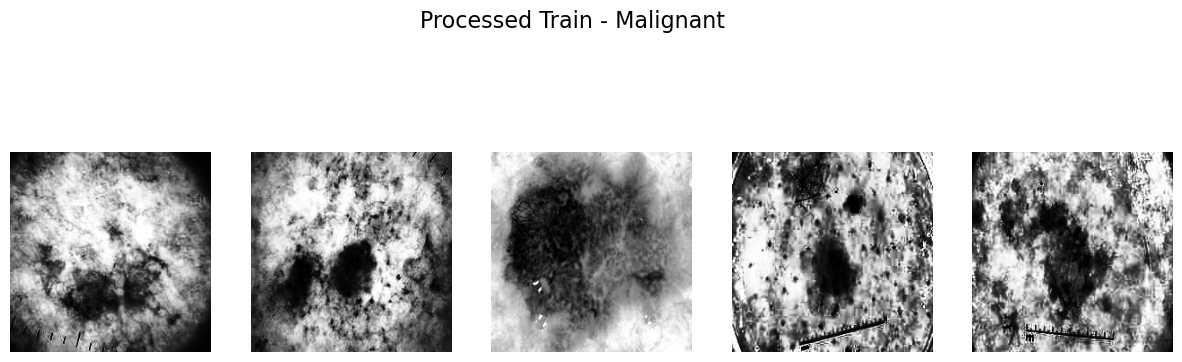

Imagens do diretório processado de teste:


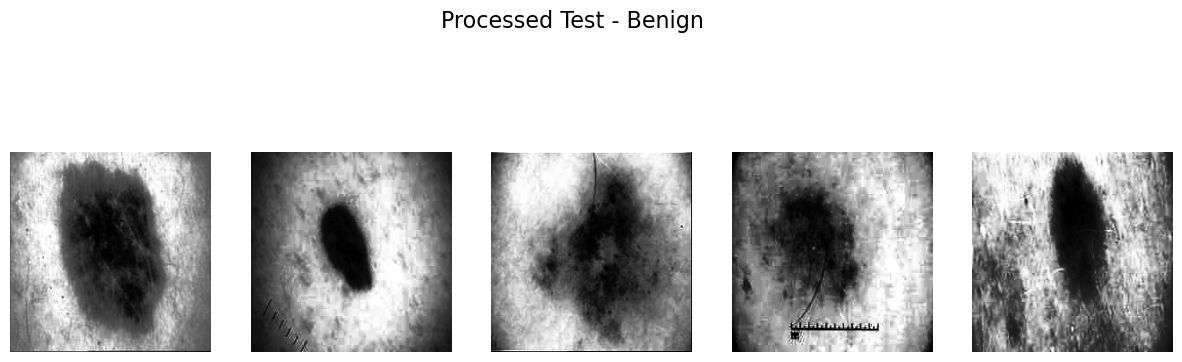

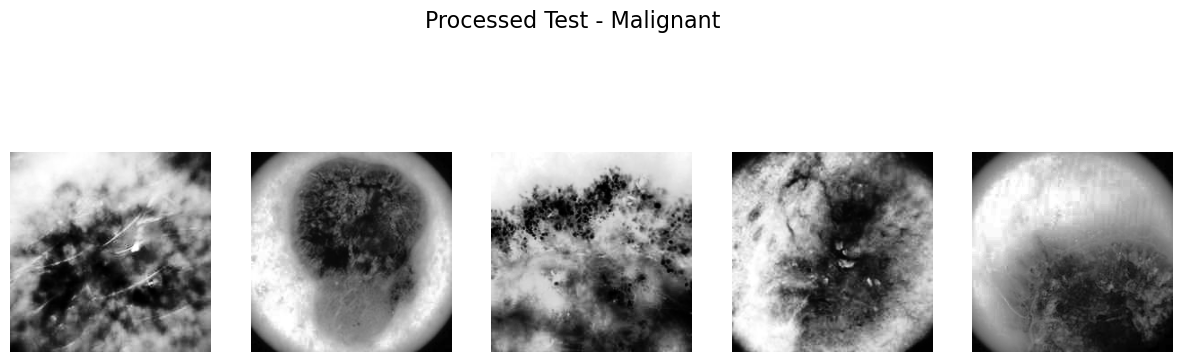

In [42]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_images_from_directory(directory, title, num_images=5):
    """
    Função para exibir imagens de um diretório específico.

    :param directory: Diretório contendo as imagens.
    :param title: Título para o subplot.
    :param num_images: Número de imagens a exibir.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    # Listar arquivos no diretório
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Selecionar um número de imagens a exibir
    for ax, filename in zip(axes, filenames[:num_images]):
        image_path = os.path.join(directory, filename)
        image = Image.open(image_path)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    
    plt.show()


# Exibir imagens do diretório original
print("Imagens do diretório original de treinamento:")
display_images_from_directory(os.path.join(train_dir, 'Benign'), "Original Train - Benign", num_images=5)
display_images_from_directory(os.path.join(train_dir, 'Malignant'), "Original Train - Malignant", num_images=5)

print("Imagens do diretório original de teste:")
display_images_from_directory(os.path.join(test_dir, 'Benign'), "Original Test - Benign", num_images=5)
display_images_from_directory(os.path.join(test_dir, 'Malignant'), "Original Test - Malignant", num_images=5)

# Exibir imagens do diretório processado
print("Imagens do diretório processado de treinamento:")
display_images_from_directory(os.path.join(processed_train_dir, 'Benign'), "Processed Train - Benign", num_images=5)
display_images_from_directory(os.path.join(processed_train_dir, 'Malignant'), "Processed Train - Malignant", num_images=5)

print("Imagens do diretório processado de teste:")
display_images_from_directory(os.path.join(processed_test_dir, 'Benign'), "Processed Test - Benign", num_images=5)
display_images_from_directory(os.path.join(processed_test_dir, 'Malignant'), "Processed Test - Malignant", num_images=5)


#### Carregar o dataset no TensorFlow

In [45]:
# Carregar o dataset de treino
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    processed_train_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'  # Especificar que as imagens são em escala de cinza
)

# Carregar o dataset de teste
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    processed_test_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'  # Especificar que as imagens são em escala de cinza
)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Particionamento dos Dados

In [59]:
def get_dataset_partition(ds, train_split=0.8, valid_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + valid_split <= 1), "As proporções de treinamento e validação devem somar no máximo 1"
    
    ds_size = len(ds)
    if ds_size == 0:
        raise ValueError("O dataset está vazio.")
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)
    
    if train_size + valid_size > ds_size:
        raise ValueError("Os tamanhos de particionamento excedem o tamanho do dataset.")
    
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)

    return train_ds, valid_ds

In [60]:
train_ds, valid_ds = get_dataset_partitation(train_dataset)

In [61]:
print('len train_ds:',len(train_ds))
print('len processed_test_dir:',len(processed_test_dir))
print('len valid_ds', len(valid_ds))

len train_ds: 297
len processed_test_dir: 59
len valid_ds 37


# Otimização do Carregamento de Imagens

In [63]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Redimensionando tamanho e escala

In [64]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Aumento de Dados (Data Augmentation)

In [65]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)
])

# Construindo o Modelo

#### Construindo função para monitorar treinamento

In [66]:
class ResourceMonitor(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.process = psutil.Process()
        self.cpu_usages = []
        self.memory_usages = []
        self.logs = {
            "epoch": [],
            "cpu_usage": [],
            "memory_usage": [],
            "elapsed_time": []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Capture CPU and memory usage at the end of each epoch
        cpu_usage = self.process.cpu_percent(interval=None)
        memory_info = self.process.memory_info()
        memory_usage = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
        elapsed_time = time.time() - self.train_start_time
        
        self.cpu_usages.append(cpu_usage)
        self.memory_usages.append(memory_usage)

        # Store in logs
        self.logs["epoch"].append(epoch + 1)
        self.logs["cpu_usage"].append(cpu_usage)
        self.logs["memory_usage"].append(memory_usage)
        self.logs["elapsed_time"].append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU usage: {cpu_usage}%, Memory usage: {memory_usage} MB, Elapsed time: {elapsed_time:.2f} seconds")
    
    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        self.total_training_time = self.train_end_time - self.train_start_time
        print(f"Total training time: {self.total_training_time:.2f} seconds")
        print(f"Average CPU usage: {sum(self.cpu_usages) / len(self.cpu_usages):.2f}%")
        print(f"Average Memory usage: {sum(self.memory_usages) / len(self.memory_usages):.2f} MB")
        
        # Store final training time
        self.logs["total_training_time"] = self.total_training_time
        self.logs["average_cpu_usage"] = sum(self.cpu_usages) / len(self.cpu_usages)
        self.logs["average_memory_usage"] = sum(self.memory_usages) / len(self.memory_usages)
    
    def get_logs(self):
        return self.logs

### Construção do modelo

In [72]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model_64 = tf.keras.Sequential([
    layers.Input(shape=input_shape),  # Adicionando a forma de entrada
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_64.build(input_shape=(None,) + input_shape)

model_64.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,178 (1.84 MB)

 Trainable params: 482,178 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

# Compilando e treinando o modelo

In [74]:
# Compilando o modelo

model_64.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Instanciação do callback de monitoramento de recursos

In [75]:
resource_monitor = ResourceMonitor()

#### Treinando o modelo

In [76]:
# Treinamento do modelo
history = model_64.fit(
    train_ds,  # Dados de treinamento
    epochs=EPOCHS,  # Número de épocas
    validation_data=valid_ds,  # Dados de validação
    batch_size=BATCH_SIZE,  # Tamanho do lote
    verbose=1,  # Nível de verbosidade
    callbacks=[resource_monitor]
)

# Converter os logs para um DataFrame
logs = resource_monitor.get_logs()
df = pd.DataFrame(logs)
print(df)

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6559 - loss: 0.6223Epoch 1: CPU usage: 0.0%, Memory usage: 4850.62890625 MB, Elapsed time: 212.53 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 213s 663ms/step - accuracy: 0.6561 - loss: 0.6221 - val_accuracy: 0.7399 - val_loss: 0.5855
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7476 - loss: 0.5156Epoch 2: CPU usage: 595.6%, Memory usage: 4853.42578125 MB, Elapsed time: 398.40 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 186s 626ms/step - accuracy: 0.7476 - loss: 0.5157 - val_accuracy: 0.7483 - val_loss: 0.5144
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7608 - loss: 0.4989Epoch 3: CPU usage: 613.3%, Memory usage: 4855.3203125 MB, Elapsed time: 578.79 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 180s 607ms/step - accuracy: 0.7608 - loss: 0.4989 - val_accuracy: 0.7787 - val_loss: 0.4658
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7650 - loss: 0.4834Epoch 4: CPU usage: 606.6

#### Monitorando o Treinamento

- coleta e armazenamento de métricas de uso de recursos do sistema durante o treinamento do modelo

In [77]:
df.to_csv('resource_usage_log_model64_15ep_ppHistEq.csv', index=False)

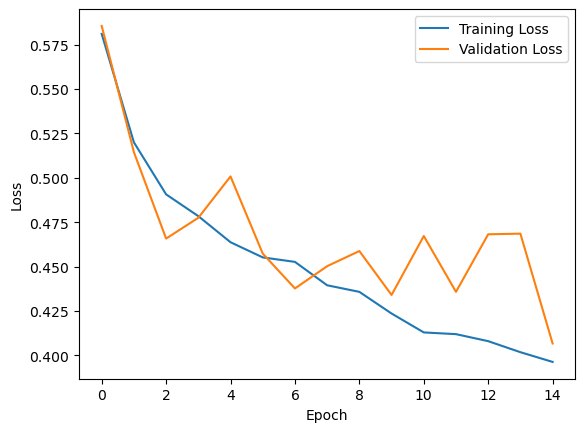

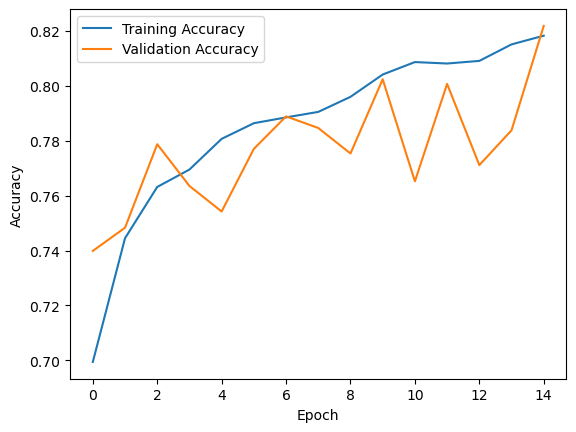

In [78]:
# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a acurácia de treinamento e validação
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Salvando o modelo

#### Salvando o modelo completo

In [79]:
# Salvar o modelo completo no formato Keras nativo
model_64.save('model64_15ep_ppHistEq.keras')


#### Salvando os pesos

In [ ]:
# # Salvar apenas os pesos
# model_64.save_weights('meus_pesos_modelo.h5')
# # Deu pau kkkkk

# Avaliar o modelo no conjunto de Test

In [80]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_64.evaluate(test_dataset)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.8291 - loss: 0.3749
Perda no teste: 0.3950
Acurácia no teste: 0.8160


In [81]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


NameError: name 'class_names' is not defined

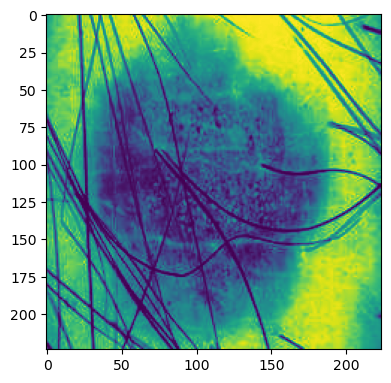

In [82]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_64, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [83]:
def evaluate_model(model, test_dataset):
    # Avaliar o modelo no conjunto de teste
    scores = model.evaluate(test_dataset)
    print(f"Loss: {scores[0]}")
    print(f"Accuracy: {scores[1]}")
    
    # Obter previsões
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(model.predict(images), axis=-1))
    
    # Relatório de classificação
    print("Classification Report")
    class_report = classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {
        "loss": scores[0],
        "accuracy": scores[1],
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "classification_report": class_report
    }
    
    # Converter as métricas em um DataFrame
    metrics_df = pd.DataFrame([metrics])
    
    return metrics_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.8249 - loss: 0.3821
Loss: 0.3949619233608246
Accuracy: 0.8159999847412109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━

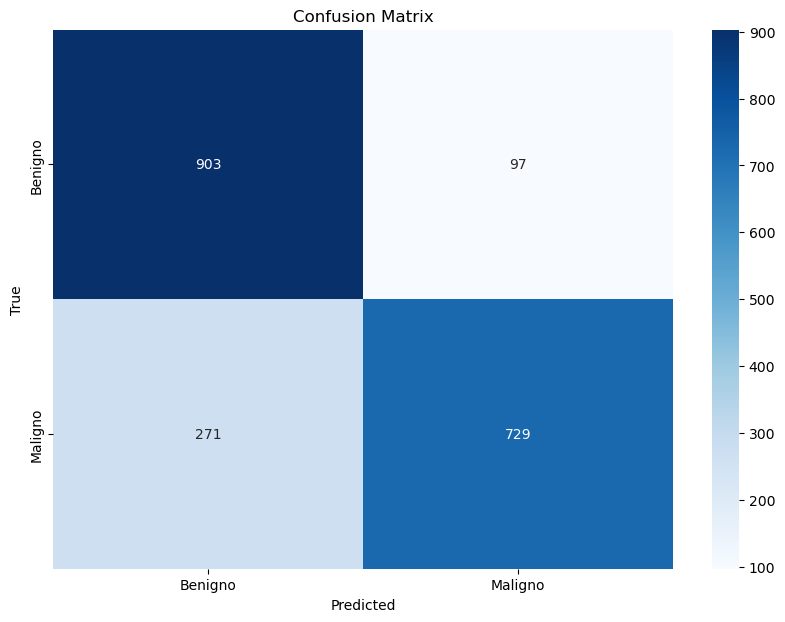

loss  accuracy  precision  recall  f1_score  \
0  0.394962     0.816   0.825866   0.816  0.814597   

                               classification_report  
0  {'Benigno': {'precision': 0.7691652470187393, ...

In [84]:
# Avaliar o modelo e obter as métricas
metrics_df = evaluate_model(model_64, test_dataset)
display(metrics_df)

#### Salvando o relatório

In [85]:
# Salvar o DataFrame em um arquivo CSV
metrics_df.to_csv('mmodel64_15ep_ppHistEq.csv', index=False)

In [ ]:
# # Criar DataFrame com a matriz de confusão
# df_cm = pd.DataFrame(cm, index=['Benign', 'Malignant'], columns=['Benign', 'Malignant'])

# # Salvar o DataFrame como CSV
# df_cm.to_csv('matriz_confusao.csv')

# # Salvar o relatório de classificação como texto
# with open('relatorio_classificacao.txt', 'w') as f:
#     f.write(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))